# Student Performance Microbenchmark
Simple statistical queries about students in a Portuguese class.
This file is adapted to use numpy only without Spark.

In [15]:
EXPERIMENT = 'pac-student_performance-sparkless'
OUTPUT_DIR = f'./outputs/{EXPERIMENT}'
GENERATE = True
USE_EVEN_NUMBER_OF_INPUT_ROWS = False
SEED_RANDOM_NUMBER_GENERATOR = True

if GENERATE:
    print("GENERATE = True, so we will generate new samples.")
else:
    print("GENERATE = False, so we will load saved output from files rather than recomputing.")

import os
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)



GENERATE = True, so we will generate new samples.


### Running PAC

In [34]:
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
if SEED_RANDOM_NUMBER_GENERATOR:
    np.random.seed(0)

import pandas as pd
from pandas import DataFrame
import concurrent.futures
import pyarrow as pa
import pyarrow.parquet as pq
import pickle
from numpy.random import laplace
from functools import reduce
import operator
from scipy import special

In [17]:
### Mayuri's conversion functions between DP epsilon and PAC MI using posterior advantage for equivalence
def calc_posterior(mi, prior=0.5, prec = 100000):
    test_vals = [x / prec for x in range(1, prec)]
    max_t = None
    for t in test_vals:
        if t*np.log(t/prior)+(1-t)*np.log((1-t)/(1-prior)) <= mi:
            if  max_t is None or t > max_t:
                max_t = t
    return max_t

def dp_epsilon_to_posterior_success(epsilon):
    return 1 - 1./(1+np.exp(epsilon))

def dp_ps_to_epsilon(ps):
    return np.log(ps / (1-ps))

# example usage:


In [18]:
### Data Setup
por_df = pq.read_table(f"./data/student_performance/student-por.parquet").to_pandas()
# drop last row
if USE_EVEN_NUMBER_OF_INPUT_ROWS:
    if por_df.shape[0] % 2 != 0:
        print(f"Input data has odd number of rows ({por_df.shape[0]}), dropping last row to make it even.")
        por_df = por_df.iloc[:-1]
por_df.shape

(649, 33)

In [20]:
max(por_df['absences'])

32

In [21]:
true_result = por_df['absences'].agg(['count', 'sum', 'mean']).to_numpy()
true_result

array([ 649.        , 2375.        ,    3.65947612])

In [22]:
### Query Setup
SAMPLES = 10000
assert SAMPLES % 2 == 0, "We need an even number of samples for paired sampling."
number_of_pairs = SAMPLES // 2

true_result = por_df['absences'].agg(['count', 'sum', 'mean']).to_numpy() # Save the true result of the query for later
number_of_contributing_rows = por_df['absences'].count()

def paired_samples(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    """
    This will select a subset of indices, where each index is selected with probability 0.5.
    The first result is the dataframe composed of the selected rows.
    The second result is the complement / the dataframe composed of the rows that were not selected.
    """
    indices = []
    n = len(df)
    t=list(df.index)
    np.random.shuffle(t)
    selected = t[:int(n/2)]
    not_indices = list(set(df.index) - set(selected))
    selected: DataFrame = df.iloc[selected]
    not_selected: DataFrame = df.iloc[not_indices]
    return (selected, not_selected)

def run_query(i: int) -> List[np.ndarray]:
    # i is not used for anything, just to satisfy the map function.
    # Returns two results each invocation as a result of paired sampling.
    results = []
    for temp_df in paired_samples(por_df):
        out_df = temp_df['absences'].agg(['count', 'mean'])  # run the query
        #out_df['count'] *= 2  # correct query result for the 50% subsampling
        #out_df['sum'] *= 2  # correct query result for the 50% subsampling
        results.append(out_df.to_numpy())
    return results

def generate_samples(laplace_lambda: float = 1.0, alpha: int = 10) -> List[np.ndarray]:
    # thresholding happens here for PAC -- if there are less than alpha samples
    # (with some Laplacian noise), then we don't subsample and return None.
    laplace_noise: float = np.random.laplace(scale=laplace_lambda)
    if number_of_contributing_rows + laplace_noise < alpha:  # if we don't get enough results from the query
        print("There are not enough rows contributing to the result for PAC to be meaningful.")
        return []
    
    out_np: List[np.ndarray] = []
    for i in range(number_of_pairs):
        out_np.append(run_query(i))
    out_np = reduce(operator.iconcat, out_np, [])
    # https://stackoverflow.com/a/45323085

    #with concurrent.futures.ThreadPoolExecutor() as executor:
    #    out_np: List[np.ndarray] = list(executor.map(run_query, range(number_of_pairs)))
    #    out_np = reduce(operator.iconcat, out_np, [])
    #    # https://stackoverflow.com/a/45323085

    return out_np

In [23]:
#s = generate_samples()
#s

#pd.DataFrame(s, columns=['count', 'mean']).hist("count")
#pd.DataFrame(s, columns=['count', 'mean']).hist("sum")
#pd.DataFrame(s, columns=['count', 'mean']).hist("mean")

In [24]:
# compute variance of pd.DataFrame(s, columns=['count', 'mean'])['sum']
#np.var(pd.DataFrame(s, columns=['count', 'mean'])['count'])

In [35]:
### Compute PAC Noise
def updateDataFrame(vec: np.ndarray, df: DataFrame) -> DataFrame:
    """
    Update a DataFrame with a noisy output vector.
    """
    noisy_output_df = df.copy()
    noisy_output_df.loc[0] = vec
    return noisy_output_df

saved_pac_variables = []
# (out_np[0], fin_var, sqrt_total_var, pac_noise, pac_noises_to_add, pac_release)

def get_pac_noise(variance, max_mi):
        
    sqrt_total_var: np.floating[Any] = np.sum(np.sqrt(variance))
    pac_noise: np.ndarray = (1./(2*max_mi)) * sqrt_total_var * np.sqrt(variance)  # variance of the PAC noise
    return pac_noise

def do_pac_and_release(variance: List[np.ndarray],
                       max_mi: float,
                       chosen_sample: List[np.ndarray]) -> np.ndarray:
    pac_noise = get_pac_noise(variance, max_mi)
    pac_noises_to_add: np.ndarray = np.random.normal(loc=0, scale=pac_noise)

    pac_release = chosen_sample + pac_noises_to_add
    
    return pac_release


In [37]:
experiment_results = []
experiment_results_unnoised = []

out_np = generate_samples() # generate samples (results of running the query)
dimensions: int = len(out_np[0])

out_np_2darr = [np.atleast_2d(o) for o in out_np] # make sure all the DF -> np.ndarray conversions result in 2d arrays

est_y: np.ndarray = np.stack(out_np_2darr, axis=-1).reshape(dimensions, SAMPLES)
fin_var: np.ndarray = np.var(est_y, axis=1)  # shape (dimensions,)


NameError: name 'use_svd' is not defined

In [40]:
use_svd=True
if use_svd:
    cov = np.cov(est_y)
    fin_var: np.linalg.eig(cov)[0]
print(fin_var)

[0.25       0.03307318]


In [142]:
# MEAN
mis = [2**x for x in range(-10, 3)]
dp = []
pac = []
for mi in mis:
    eps = dp_ps_to_epsilon(calc_posterior(mi))
    dp_sensitivity = max(por_df['absences']) / len(por_df)
    laplace_var = dp_sensitivity / eps
    variance = np.array([fin_var[1]])
    sqrt_total_var: np.floating[Any] = np.sum(np.sqrt(variance))
    pac_var: np.ndarray = (1./(2*mi)) * sqrt_total_var * np.sqrt(variance)
    dp.append(laplace_var)
    pac.append(pac_var)

Text(0.5, 1.0, 'Noise for Mean Estimation')

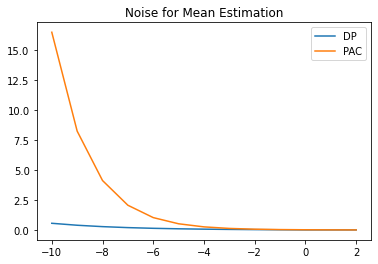

In [143]:
xs = [x for x in range(-10, 3)]
plt.plot(xs, dp, label='DP')
plt.plot(xs, pac, label='PAC')
plt.legend()
plt.title("Noise for Mean Estimation")

In [136]:
# COUNT
mis = [2**x for x in range(-10, 3)]
dp = []
pac = []
for mi in mis:
    eps = dp_ps_to_epsilon(calc_posterior(mi))
    dp_sensitivity = 1.
    laplace_var = dp_sensitivity / eps
    variance = np.array([fin_var[0]])
    sqrt_total_var: np.floating[Any] = np.sum(np.sqrt(variance))
    pac_var: np.ndarray = (1./(2*mi)) * sqrt_total_var * np.sqrt(variance)
    dp.append(laplace_var)
    pac.append(pac_var)

Text(0.5, 1.0, 'Noise for Count Estimation')

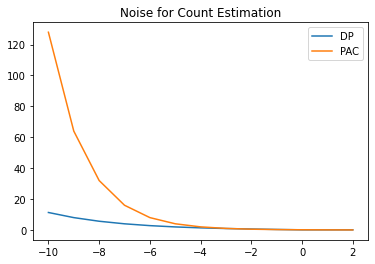

In [141]:
xs = [x for x in range(-10, 3)]
plt.plot(xs, dp, label='DP')
plt.plot(xs, pac, label='PAC')
plt.legend()
plt.title("Noise for Count Estimation")

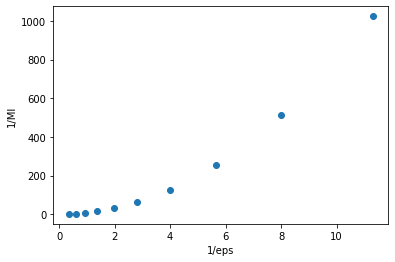

In [168]:
ys = [1./2**(x) for x in range(-10, 0)]
orig = [2**x for x in range(-10, 0)]
xs = [1./dp_ps_to_epsilon(calc_posterior(x)) for x in orig]
plt.ylabel("1/MI")
plt.xlabel("1/eps")
plt.plot(xs, ys, 'o')

In [162]:
np.log2(dp_ps_to_epsilon(calc_posterior(2**-6)))

-1.4887432461805226

In [161]:
np.log2(dp_ps_to_epsilon(calc_posterior(2**-8)))

-2.4973520666824283